## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

## Load

In [3]:
adata = sc.read('data/somitoid.h5ad')

## Pre process

In [4]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=65000)
sc.pp.filter_cells(adata, min_genes=3000)
sc.pp.filter_cells(adata, max_genes=8000)

In [5]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [6]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
adata = adata[adata.obs['pct_counts_mito'] < 10, :]

In [7]:
adata.raw = adata

In [8]:
sc.pp.normalize_total(adata)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500)

In [11]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'phase' as categorical


In [12]:
sc.pp.scale(adata)

In [13]:
sc.tl.pca(adata, n_comps=50)

In [14]:
sce.pp.bbknn(adata, batch_key='timepoint', local_connectivity=9)

In [15]:
sc.tl.umap(adata)

In [16]:
sc.tl.leiden(adata, resolution=1)

In [17]:
adata.obs['leiden'] = adata.obs['leiden'].replace(['0'],'PSM Post')
adata.obs['leiden'] = adata.obs['leiden'].replace(['1'],'PSM Ant')
adata.obs['leiden'] = adata.obs['leiden'].replace(['2'],'iPSC')
adata.obs['leiden'] = adata.obs['leiden'].replace(['3'],'Somite')
adata.obs['leiden'] = adata.obs['leiden'].replace(['4'],'NMP')
adata.obs['leiden'] = adata.obs['leiden'].replace(['5'],'PSM Ant')

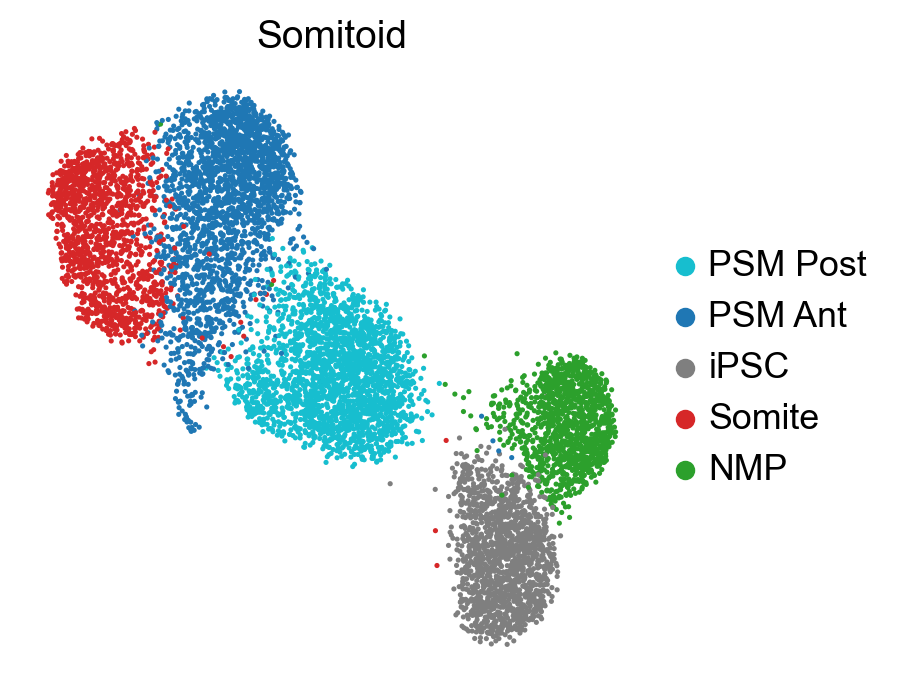

In [30]:
sc.pl.umap(adata, color=['leiden'], title='Somitoid', palette=['tab:cyan', 'tab:blue', 'tab:gray', 'tab:red', 'tab:green'])

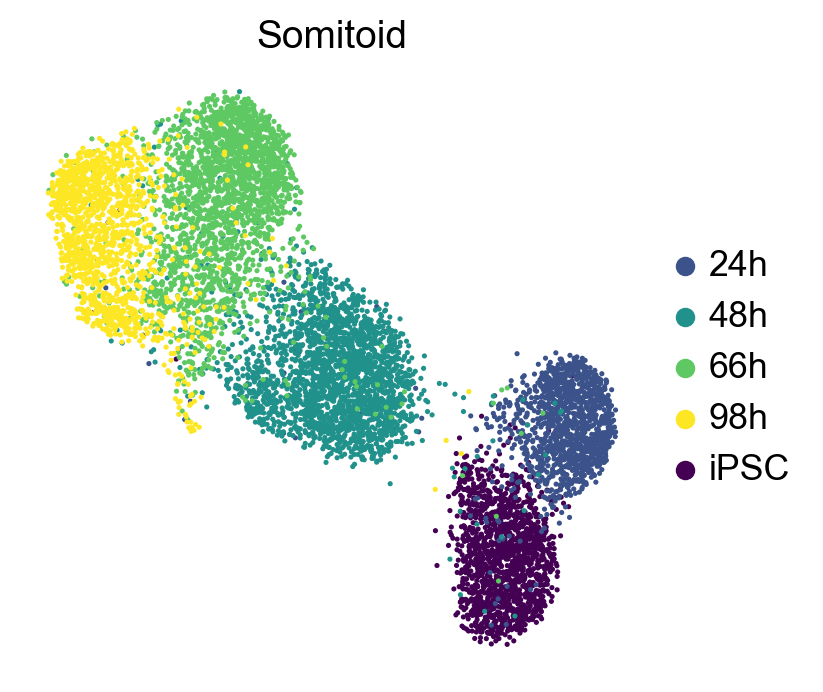

In [19]:
sc.pl.umap(adata, color=['timepoint'], title='Somitoid', palette=['#3b528b', '#21918c', '#5ec962', '#fde725', '#440154'])

## Gene expression

In [20]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=True, method='wilcoxon', corr_method='benjamini-hochberg')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:5,:]

,PSM Post,PSM Ant,iPSC,Somite,NMP
0,HES6,MEST,TERF1,SEPTIN11,GAL
1,MSGN1,SLC5A3,CD24,IGFBP5,CNTNAP2
2,TTC29,FOXC2,FOXD3-AS1,PAX3,NODAL
3,RSPO3,MRPS6,THY1,MUSTN1,MIXL1
4,RBP1,HOXB-AS3,SOX2,NRP2,LINC01356


In [21]:
order_dotplot = ['iPSC', 'NMP', 'PSM Post', 'PSM Ant', 'Somite']

In [22]:
markers = ['SOX2', 'POU5F1', 'NKX1-2', 'TBXT', 'PAX6', 'HES7', 'MSGN1', 'TBX6', 'DLL1', 'RIPPLY2', 'MEOX1', 'MESP2', 'TCF15', 
          'MYOCD', 'UNCX', 'TBX18', 'PAX3']

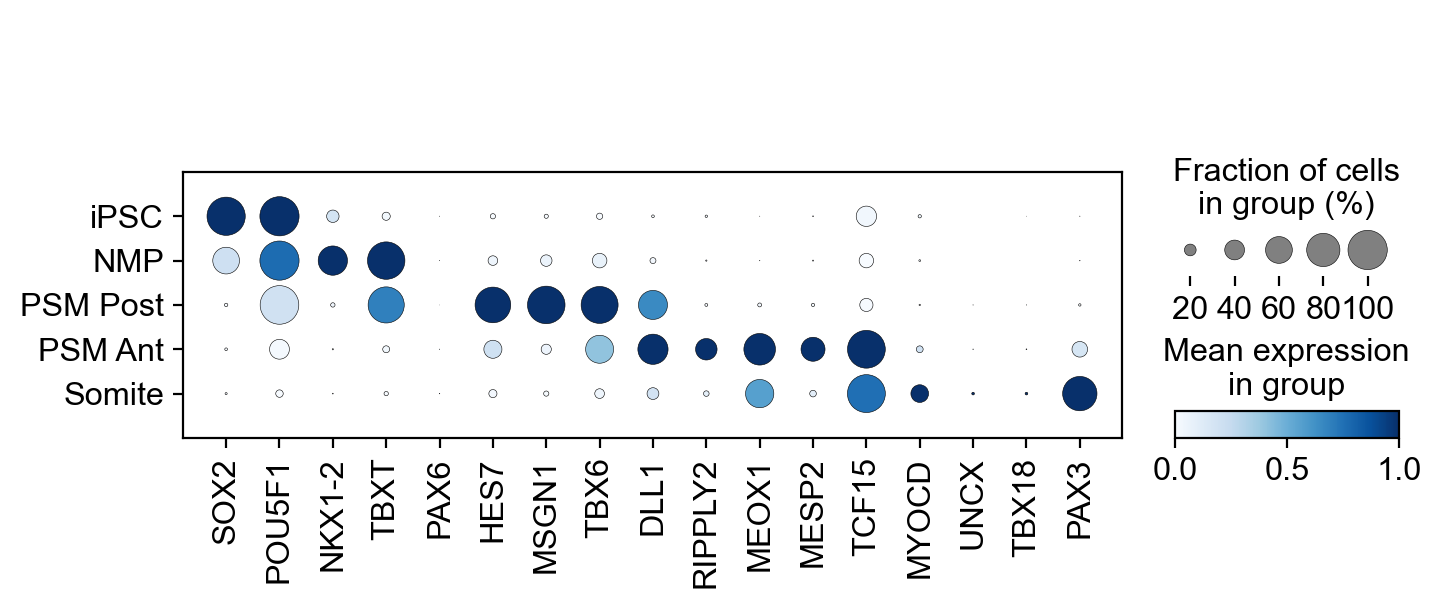

In [23]:
sc.pl.dotplot(adata, markers, 'leiden', categories_order=order_dotplot, return_fig=False,color_map='Blues', standard_scale='var')

## TBX18 / UNCX

In [31]:
adata_df = pd.DataFrame(adata.raw.X.toarray(), index = adata.obs.index, columns = adata.raw.var.index)
index_TBX18 = adata_df[adata_df.TBX18 > 0].index 
adata_TBX18 = adata[adata.obs.index.isin(index_TBX18)]
adata_TBX18.obs['gene_subset'] = 'TBX18'
print('TBX18+ cells : ' + str(adata_TBX18.shape[0]))

Trying to set attribute `.obs` of view, copying.


TBX18+ cells : 56


In [32]:
adata_df = pd.DataFrame(adata.raw.X.toarray(), index = adata.obs.index, columns = adata.raw.var.index)
index_UNCX = adata_df[adata_df.UNCX > 0].index 
adata_UNCX = adata[adata.obs.index.isin(index_UNCX)]
adata_UNCX.obs['gene_subset'] = 'UNCX'
print('UNCX+ cells : ' + str(adata_UNCX.shape[0]))

Trying to set attribute `.obs` of view, copying.


UNCX+ cells : 50


In [33]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
print('TBX18+ and UNCX+ cells : ' + str(len(intersection(adata_TBX18.obs_names.to_list(), adata_UNCX.obs_names.to_list()))))

TBX18+ and UNCX+ cells : 0


## Save

In [35]:
adata.write('data/somitoid_post.h5ad')